In [1]:
%matplotlib inline
%load_ext tensorboard

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras  # tf.keras
import time

2023-05-25 19:37:28.867314: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
matplotlib 3.5.3
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.9.0
keras.api._v2.keras 2.9.0


In [4]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [6]:
from datetime import datetime, timedelta
import sys 
sys.path.append('..')
from config import *
import json


In [7]:
def intervalToMilliseconds(interval):
    """Convert a Binance interval string to milliseconds

    :param interval: Binance interval string 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w
    :type interval: str

    :return:
        None if unit not one of m, h, d or w
        None if string not in correct format
        int value of interval in milliseconds
    """
    ms = None
    seconds_per_unit = {
        "m": 60,
        "h": 60 * 60,
        "d": 24 * 60 * 60,
        "w": 7 * 24 * 60 * 60
    }

    unit = interval[-1]
    if unit in seconds_per_unit:
        try:
            ms= int(interval[:-1]) * seconds_per_unit[unit] * 1000
        except ValueError:
            pass
    return ms

In [8]:
# path = "18-01-01-00-00-23-05-20-05-55-1h" #
path = "18-01-01-00-00-23-05-20-20-23-5m"
# path = "18-01-01-00-00-23-05-20-09-11-1d"

table = np.load( os.path.join( "/mnt/data/Trading/Candles", "table-" + path + ".npy") )
table = np.swapaxes(table, 0, 1)
print("table: {}".format(table.shape))

table: (565633, 336, 10)


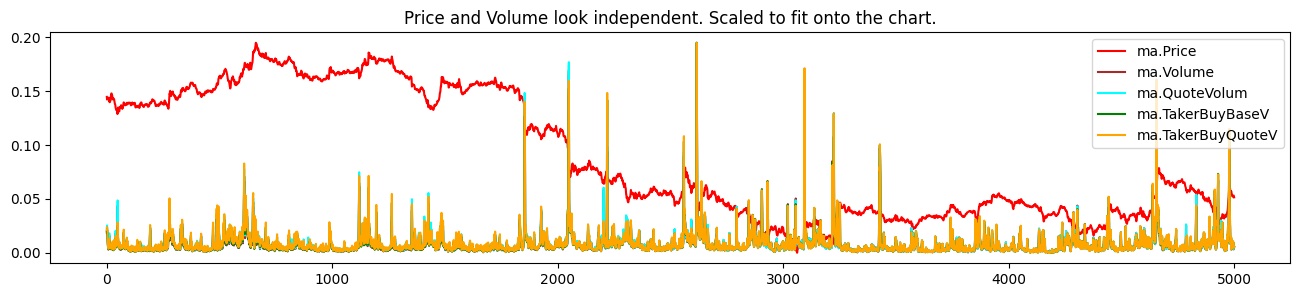

In [9]:
from Mike_NB_01 import *

market = 5
Show_Price_Volume_10(table[:, market, :], 1, 1, 5000)

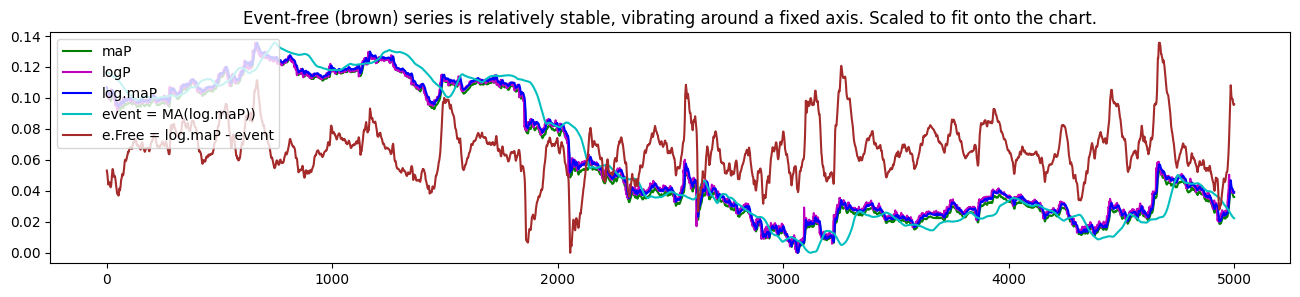

In [10]:
Event_Free_Learning_Scheme_10(table[:, market, :], 3, 30, 5000)

In [11]:
marks = table[:, :, 9] # keep it for later use

table = np.delete(table, [0, 1, 2, 5, 6, 8, 9], axis = 2) # delete Open, High, Low, qVolume, #Trades, bQVolume, Marks

from enum import Enum
class Fields(Enum):
    Close = 0       # closing price
    Volume = 1      # base volume
    bVolume = 2     # buyer base volume

table_markets = []
with open( os.path.join( Config['BinanceCandlesNumpy'], "reports-" + path + ".json"), "r") as f:
    reports = json.loads(f.read())
print(reports[:2])

markets = [ s[0: s.find(':')] for s in reports if 'Success' in s ]
assert table.shape[1] == len(markets)
print(table.shape, len(markets), markets[:2])

['ALICEUSDT: 565633, 336924 created. Success. 1-th.', 'DOTUSDT: 565633, 277039 created. Success. 2-th.']
(565633, 336, 3) 336 ['ALICEUSDT', 'DOTUSDT']


In [12]:
# restore timestamps

start = datetime( 2000+int(path[0:2]), int(path[3:5]), int(path[6:8]), int(path[9:11]), int(path[12:14]) )
start_ts = round(datetime.timestamp(start))
interval = path[ path.find('-', len(path) - 4) + 1 : ]
interval_s = round(intervalToMilliseconds(interval) / 1000)
timestamps = np.array( range(start_ts, start_ts + table.shape[0] * interval_s, interval_s), dtype=int)
assert timestamps.shape[0] == table.shape[0]
print(start_ts, interval_s, timestamps.shape, timestamps[:3])

1514764800 300 (565633,) [1514764800 1514765100 1514765400]


In [13]:
# # Find market clusters
# from sklearn.metrics import pairwise

# distances = np.zeros( (table.shape[1], table.shape[1]), dtype=float)

# # Find dependency distance
# for m in range(table.shape[1]):
#     distances[m, m] = 0.
#     for n in range(m+1, table.shape[1]):
#         mask = (marks[:, m] + marks[:, n] == 0) # marks == 0 : true full candles, marks = -1: price interpolated , marks = -2: coincodex prices
#         pm = table[mask, m, 0][np.newaxis]
#         pn = table[mask, n, 0][np.newaxis]
#         distances[m, n] = sklearn.metrics.pairwise.cosine_distances(pm, pn)
#         distances[n, m] = distances[m, n]

In [14]:
# from sklearn.cluster import OPTICS
# clustering = OPTICS(metric='precomputed', n_jobs=-1).fit(distances)
# print( clustering.labels_ )

# np.reshape(np.argwhere(clustering.labels_ == 1), -1)

# market_clusters = [ [ markets[ id ] for id in np.reshape(np.argwhere(clustering.labels_ == label), -1) ] for label in range(np.max(clustering.labels_))]
# print(market_clusters)

In [15]:
# cluster = 0
# ids = np.reshape(np.argwhere(clustering.labels_ == cluster), -1)
# series = [ [table[:, id, 0], markets[id] ] for id in ids ]
# PoltNormalized("Market cluster 0. Recent prices are mediocre. Shorter history.", series, color = 'auto')

In [16]:
# cluster = 1
# ids = np.reshape(np.argwhere(clustering.labels_ == cluster), -1)
# series = [ [table[:, id, 0], markets[id] ] for id in ids ]
# PoltNormalized("Market cluster 1. Vanished recently. Shorter history, Trends later", series, color = 'auto')

In [17]:
# cluster = 2
# ids = np.reshape(np.argwhere(clustering.labels_ == cluster), -1)
# series = [ [table[:, id, 0], markets[id] ] for id in ids ]
# PoltNormalized("Market cluster 2. Not vanished recently. Longer hostory. Trends earlier", series, color = 'auto')

In [18]:
def save_to_multiple_csv_files(data, sample_anchors, name_prefix, Nx, x_indices, Ny, y_indices, header=None, n_parts=10):
    path_format = "{}_{:02d}.csv"

    filenames = []
    for file_idx, anchors in enumerate(np.array_split(sample_anchors, n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filenames.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for anchor in anchors:
                x = np.reshape(data[anchor: anchor + Nx][:, x_indices[0]][:, :, x_indices[1]], -1)
                f.write(",".join([str(col) for col in x]))
                y = np.reshape(data[anchor + Nx: anchor + Nx + Ny][:, y_indices[0]][:, :, y_indices[1]], -1)
                f.write("," + ",".join([str(col) for col in y]))
                f.write("\n")
    return filenames

In [19]:
def parse_csv_line(line, Nx, size_x, Ny, size_y):
    print(line)
    defs = [tf.constant(0.0)] * (Nx * size_x + Ny * size_y)
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack( tf.reshape(fields[: Nx * size_x], [Nx, -1] ) )    # sequence of Nx tokens, each of size_x
    y = tf.stack(fields[Nx * size_x :])
    return x, y

In [20]:
def csv_reader_dataset(filenames, Nx, size_x, Ny, size_y, n_parse_threads=5, batch_size=2, shuffle_buffer_size=10000, n_readers=5):
    dataset = tf.data.Dataset.list_files(filenames)
    # dataset = dataset.repeat()
    dataset = dataset.interleave(
        lambda filename: tf.data.TextLineDataset(filename), #.skip(1), as we have no headers.
        cycle_length=n_readers)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(lambda x: parse_csv_line(x, Nx, size_x, Ny, size_y), num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset #.prefetch(1)

In [21]:
def get_timepoint_size(indices):
    size = 1
    for ids in indices:
        size *= len(ids)
    return size

In [22]:
# defind Data

n_times = 1000; n_markets = 2; n_fields = 2
Data = [ [ [ time * n_markets * n_fields + market * n_fields + field for field in range(n_fields) ] for market in range(n_markets) ] for time in range(n_times)]
Data = np.array(Data, dtype=float)
print(Data.shape)   # time, market, field
print(Data[:2, :, :])

(1000, 2, 2)
[[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]


In [23]:
Nx = 2
Ny = 2
Ns = 10
BatchSize = 2

sample_anchors = range(0, Data.shape[0] - Nx - Ny, Ns)
print(Data.shape[0], len(sample_anchors), sample_anchors)

x_indices = ( (0, 1), (0, 1) )    # (market, field)
y_indices = ( (0,), (0, 1) )    # (market, field)
print(Data[0:2][:, x_indices[0]][:, :, x_indices[1]])
print(Data[2:4][:, y_indices[0]][:, :, y_indices[1]])

size_x = get_timepoint_size(x_indices)
size_y = get_timepoint_size(y_indices)
print(size_x, size_y)

1000 100 range(0, 996, 10)
[[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]
[[[ 8.  9.]]

 [[12. 13.]]]
4 2


In [24]:
dir_datasets = "/mnt/data/Trading/Datasets"
name_plus = path+'_o'
name_prefix = os.path.join(dir_datasets, name_plus)

reuse_files = False

if reuse_files:
    import re
    filenames = [ os.path.join(dir_datasets, x) for x in os.listdir(dir_datasets) if re.match(name_plus, x)]
else:
    os.system("rm {}/*{}*".format(dir_datasets, name_plus))
    filenames = save_to_multiple_csv_files(Data, sample_anchors, name_prefix, Nx, x_indices, Ny, y_indices, header=None, n_parts=10)

print(filenames)

['/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_00.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_01.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_02.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_03.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_04.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_05.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_06.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_07.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_08.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_09.csv']


In [25]:
filename_dataset = tf.data.Dataset.list_files(filenames, shuffle=None) # no way to prevent shuffle.
print(filename_dataset.cardinality().numpy())
for element in filename_dataset:
    print(element.numpy())

10
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_09.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_03.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_04.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_05.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_08.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_00.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_07.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_01.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_02.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_06.csv'


2023-05-25 19:37:41.327001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 19:37:42.010676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36425 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


In [26]:
ds = tf.data.TextLineDataset(filenames[0])
for line in ds.take(20):
    print(line.numpy())

b'0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,12.0,13.0'
b'40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,52.0,53.0'
b'80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0,92.0,93.0'
b'120.0,121.0,122.0,123.0,124.0,125.0,126.0,127.0,128.0,129.0,132.0,133.0'
b'160.0,161.0,162.0,163.0,164.0,165.0,166.0,167.0,168.0,169.0,172.0,173.0'
b'200.0,201.0,202.0,203.0,204.0,205.0,206.0,207.0,208.0,209.0,212.0,213.0'
b'240.0,241.0,242.0,243.0,244.0,245.0,246.0,247.0,248.0,249.0,252.0,253.0'
b'280.0,281.0,282.0,283.0,284.0,285.0,286.0,287.0,288.0,289.0,292.0,293.0'
b'320.0,321.0,322.0,323.0,324.0,325.0,326.0,327.0,328.0,329.0,332.0,333.0'
b'360.0,361.0,362.0,363.0,364.0,365.0,366.0,367.0,368.0,369.0,372.0,373.0'


In [27]:
n_readers = 5
dataset = filename_dataset.interleave(
    lambda filename: tf.data.TextLineDataset(filename),
    cycle_length=n_readers, num_parallel_calls=tf.data.AUTOTUNE) # no way to prevent shuffle?

for line in dataset.take(15):
    print(line.numpy())

b'3200.0,3201.0,3202.0,3203.0,3204.0,3205.0,3206.0,3207.0,3208.0,3209.0,3212.0,3213.0'
b'1600.0,1601.0,1602.0,1603.0,1604.0,1605.0,1606.0,1607.0,1608.0,1609.0,1612.0,1613.0'
b'3600.0,3601.0,3602.0,3603.0,3604.0,3605.0,3606.0,3607.0,3608.0,3609.0,3612.0,3613.0'
b'2400.0,2401.0,2402.0,2403.0,2404.0,2405.0,2406.0,2407.0,2408.0,2409.0,2412.0,2413.0'
b'0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,12.0,13.0'
b'3240.0,3241.0,3242.0,3243.0,3244.0,3245.0,3246.0,3247.0,3248.0,3249.0,3252.0,3253.0'
b'1640.0,1641.0,1642.0,1643.0,1644.0,1645.0,1646.0,1647.0,1648.0,1649.0,1652.0,1653.0'
b'3640.0,3641.0,3642.0,3643.0,3644.0,3645.0,3646.0,3647.0,3648.0,3649.0,3652.0,3653.0'
b'2440.0,2441.0,2442.0,2443.0,2444.0,2445.0,2446.0,2447.0,2448.0,2449.0,2452.0,2453.0'
b'40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,52.0,53.0'
b'3280.0,3281.0,3282.0,3283.0,3284.0,3285.0,3286.0,3287.0,3288.0,3289.0,3292.0,3293.0'
b'1680.0,1681.0,1682.0,1683.0,1684.0,1685.0,1686.0,1687.0,1688.0,1689.0,1692.0,1693.0'
b'3680.0,3681.

In [28]:
parse_csv_line(b'0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11.', Nx, size_x, Ny, size_y)

b'0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11.'


(<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[0., 1., 2., 3.],
        [4., 5., 6., 7.]], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 8.,  9., 10., 11.], dtype=float32)>)

In [29]:
Dataset = csv_reader_dataset(filenames, Nx, size_x, Ny, size_y,
                             n_parse_threads=5, batch_size=BatchSize, shuffle_buffer_size=10000, n_readers=5)

Tensor("args_0:0", shape=(), dtype=string)


In [30]:
for element in Dataset:
    print(element)
    break

# should print: (None, Nx, size_x), (None, Ny * size_y)

(<tf.Tensor: shape=(2, 2, 4), dtype=float32, numpy=
array([[[1360., 1361., 1362., 1363.],
        [1364., 1365., 1366., 1367.]],

       [[2960., 2961., 2962., 2963.],
        [2964., 2965., 2966., 2967.]]], dtype=float32)>, <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[1368., 1369., 1372., 1373.],
       [2968., 2969., 2972., 2973.]], dtype=float32)>)


In [31]:
# Check elements: NaN, -inf, +inf

assert (~np.isfinite(table)).any() == False

In [32]:
def Get_Event_Free_Feature(feature, smallSigma, largeSigma, nLatest):

    def gaussian( x, s): return 1./np.sqrt( 2. * np.pi * s**2 ) * np.exp( -x**2 / ( 2. * s**2 ) )

    smallSigma = min(math.floor(feature.shape[0]/3), smallSigma)
    smallP = 3 * smallSigma
    smallKernel = np.fromiter( (gaussian( x , smallSigma ) for x in range(-smallP+1, 1, 1 ) ), float ) # smallP points, incl 0.
#     print("smallKernel: {}".format(smallKernel))
    maP = np.convolve(feature, smallKernel, mode="valid") / np.sum(smallKernel) # maps to feature[smallP-1:]

    # maP = maP / np.min(1.0, np.min(maP[np.where(maP>0.0)]))
    nzPs = np.where(maP > 0.0)[0] [smallP:]    # to exclude initial nearly-zero values.
    log_maP = np.zeros( maP.shape, dtype=maP.dtype)
    log_maP[nzPs] = np.log2(maP[nzPs])  #------------------------------------------ Log danger ------------

    # log_maP = np.log2(maP + 1e-9) # maps to feature[smallP-1:]

    largeSigma = min(math.floor(feature.shape[0]/3), largeSigma)
    largeP = 3 * largeSigma
    largeKernel = np.fromiter( (gaussian( x , largeSigma ) for x in range(-largeP+1, 1, 1 ) ), float ) # largeP points, incl 0.
#     print("largeKernel: {}".format(largeKernel))
    event = np.convolve(log_maP, largeKernel, mode="valid") / np.sum(largeKernel) # maps to log_maP[largeP-1:], so to feature[smallP+largeP-2:]

    assert event.shape[0] == feature.shape[0] - (smallP+largeP-2)
    log_maP1 = log_maP[largeP-1:] # maps to log_maP[largeP-1:], so to feature[smalP+largeP-2:]
    assert log_maP1.shape[0] == feature.shape[0] - (smallP+largeP-2)
    P1 = feature[smallP+largeP-2:]
    assert P1.shape[0] == feature.shape[0] - (smallP+largeP-2)
    eventFree = log_maP1 - event # maps to feature[smallP+largeP-2:]

    nLatest = min(feature.shape[0] - (smallP+largeP-2), nLatest)
    P2 = P1[-nLatest:]
    maP2 = maP[-nLatest:]

    # P2 = P2 / np.min(1.0, np.min(P2[np.where(P2>0.0)]))
    nzPs = np.where(P2 > 0.0) [0] [:]
    logP2 = np.zeros( P2.shape, dtype=P2.dtype)
    logP2[nzPs] = np.log2(P2[nzPs]) #------------------------------------------ Log danger ------------

    # logP2 = np.log2(P2 + 1e-9) 
    
    log_maP2 = log_maP1[-nLatest:]
    event2 = event[-nLatest:]
    eventFree2 = eventFree[-nLatest:] # maps to candle[p1-1+p2-1+begin: p1-1+p2-1+begine+width]

    return P2, maP2, logP2, log_maP2, event2, eventFree2    # eventFree = log_maP - event, event = convolve(lag_maP, leftKernel) / sum(leftKernel)


In [33]:
nLatest = 500
P, maP, logP, log_maP, event, eventFree = Get_Event_Free_Feature(table[:, 0, 0], 1, 30, nLatest)
assert maP.shape[0] == nLatest; assert logP.shape[0] == nLatest; assert log_maP.shape[0] == nLatest; assert event.shape[0] == nLatest; assert eventFree.shape[0] == nLatest


In [34]:
def get_plot_log_feature(market, field, feature, smallSigma, largeSigma, nLatest):
    P, maP, logP, log_maP, event, eventFree = Get_Event_Free_Feature(feature, 1, 30, nLatest)
    series = [ [maP, "maP", "g"], [logP, "logP" ,"m"], [log_maP, "log.maP", "b"], [event, "event", "c"],  [eventFree, "e.Free", "brown"] ] #, [P, "raw feature", "r"] ]
    PoltNormalized("Event-free (brown) {} on {}".format(field, market), series)
    return P, maP, logP, log_maP, event, eventFree

In [35]:
# Define Data
enFields = ['ClosePrice', 'BaseVolume', 'BuyerBaseVolume']

# dot, 1inch, btc, eth, matic, bnb, ada, sol, ltc, avax, wbtc, link, arb, ape, aave, crv, sui, op, gmx, agix, bal, comp, gmt, joe, stg
chosen_markets_x = ['DOTUSDT', '1INCHUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'ADAUSDT', 'LTCUSDT', 'AVAXUSDT', 'WBTCUSDT', 'LINKUSDT',
                  'ARBUSDT', 'APEUSDT', 'SUIUSDT', 'OPUSDT', 'GMXUSDT', 'AGIXUSDT', 'BALUSDT', 'COMPUSDT', 'GMTUSDT', 'JOEUSDT', 'STGUSDT']
chosen_markets_x = tuple([ markets.index(elem) for elem in chosen_markets_x ])
chosen_markets_x = tuple(list(set(chosen_markets_x)))
chosen_fields_x = ['ClosePrice'] #, 'BaseVolume']
chosen_fields_x = tuple( [ enFields.index(elem) for elem in chosen_fields_x ] )
chosen_fields_x = tuple(list(set(chosen_fields_x)))
x_indices = ( chosen_markets_x, chosen_fields_x )
print(x_indices)

chosen_markets_y = ['DOTUSDT', '1INCHUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'ADAUSDT', 'LTCUSDT', 'AVAXUSDT', 'WBTCUSDT', 'LINKUSDT', ]
chosen_markets_y = tuple([ markets.index(elem) for elem in chosen_markets_y ])
chosen_markets_y = tuple(list(set(chosen_markets_y)))
chosen_fields_y = ['ClosePrice']
chosen_fields_y = tuple( [ enFields.index(elem) for elem in chosen_fields_y ] )
chosen_fields_y = tuple(list(set(chosen_fields_y)))
y_indices = ( chosen_markets_y, chosen_fields_y )
print(y_indices)

size_x = get_timepoint_size(x_indices)
size_y = get_timepoint_size(y_indices)
print(size_x, size_y)

chosen_markets = tuple(list(set(chosen_markets_x + chosen_markets_y)))
chosen_fields = tuple(list(set(chosen_fields_x + chosen_fields_y)))
print(chosen_markets, chosen_fields)

((1, 2, 3, 4, 6, 8, 11, 15, 16, 17, 155, 156, 30, 32, 57, 59, 61, 79, 94, 95, 104), (0,))
((1, 2, 3, 4, 6, 8, 11, 15, 16, 17), (0,))
21 10
(1, 2, 3, 4, 6, 8, 11, 15, 16, 17, 155, 156, 30, 32, 57, 59, 61, 79, 94, 95, 104) (0,)


In [36]:
# Define Data
Data = table[:, :, :]   # (time:, all markets, 20 fields)
print(Data.shape)
assert Data.shape[1] == len(markets)
assert Data.shape[2] == len(enFields)

(565633, 336, 3)


In [37]:
check = [ (markets[m], "\tpre-padded zeros: {}%".format(int(np.argmax(Data[:, m, 0]>0) / Data.shape[0] * 100)) ) for m in chosen_markets ]
for item in check:
    print(item)

('DOTUSDT', '\tpre-padded zeros: 48%')
('1INCHUSDT', '\tpre-padded zeros: 55%')
('BTCUSDT', '\tpre-padded zeros: 0%')
('ETHUSDT', '\tpre-padded zeros: 0%')
('BNBUSDT', '\tpre-padded zeros: 0%')
('ADAUSDT', '\tpre-padded zeros: 5%')
('LTCUSDT', '\tpre-padded zeros: 0%')
('AVAXUSDT', '\tpre-padded zeros: 50%')
('WBTCUSDT', '\tpre-padded zeros: 98%')
('LINKUSDT', '\tpre-padded zeros: 19%')
('JOEUSDT', '\tpre-padded zeros: 74%')
('STGUSDT', '\tpre-padded zeros: 86%')
('ARBUSDT', '\tpre-padded zeros: 97%')
('APEUSDT', '\tpre-padded zeros: 78%')
('SUIUSDT', '\tpre-padded zeros: 99%')
('OPUSDT', '\tpre-padded zeros: 82%')
('GMXUSDT', '\tpre-padded zeros: 88%')
('AGIXUSDT', '\tpre-padded zeros: 95%')
('COMPUSDT', '\tpre-padded zeros: 46%')
('BALUSDT', '\tpre-padded zeros: 48%')
('GMTUSDT', '\tpre-padded zeros: 77%')


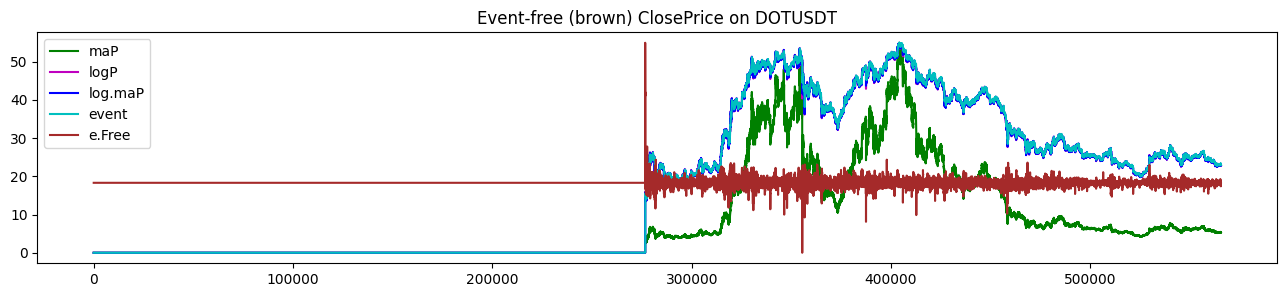

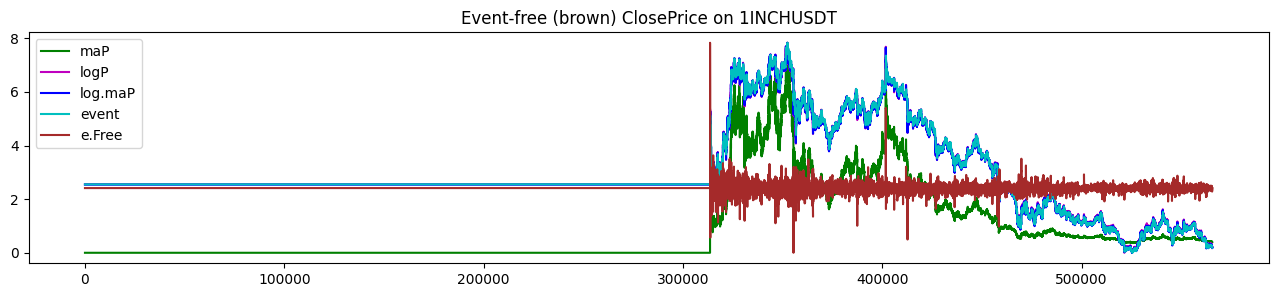

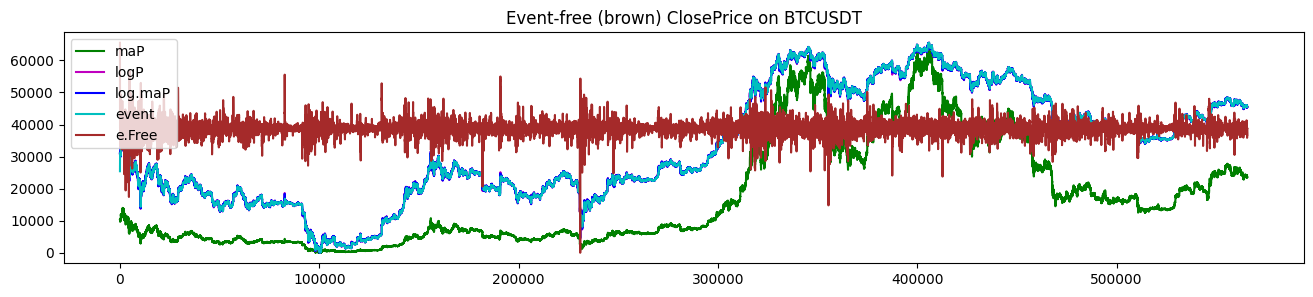

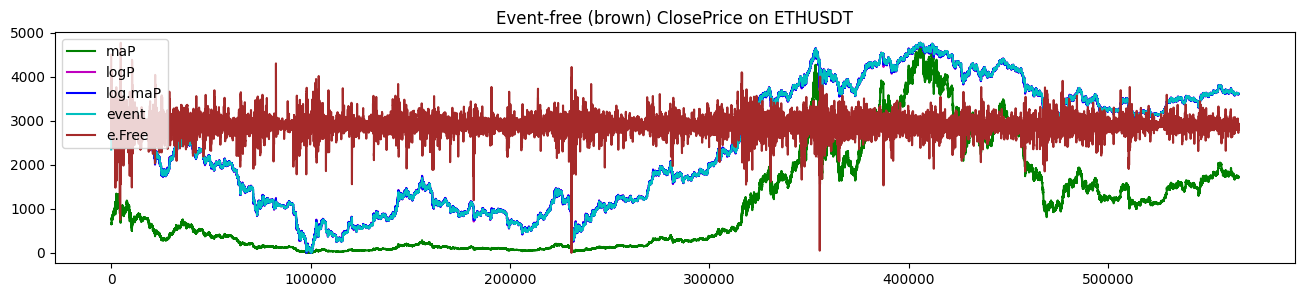

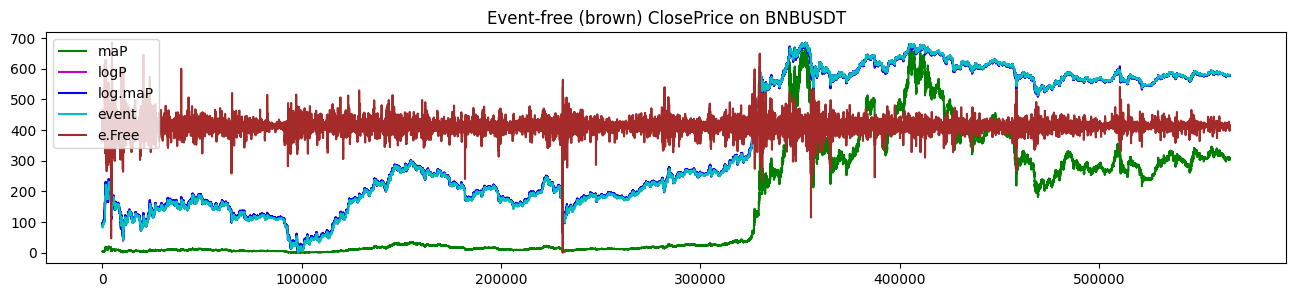

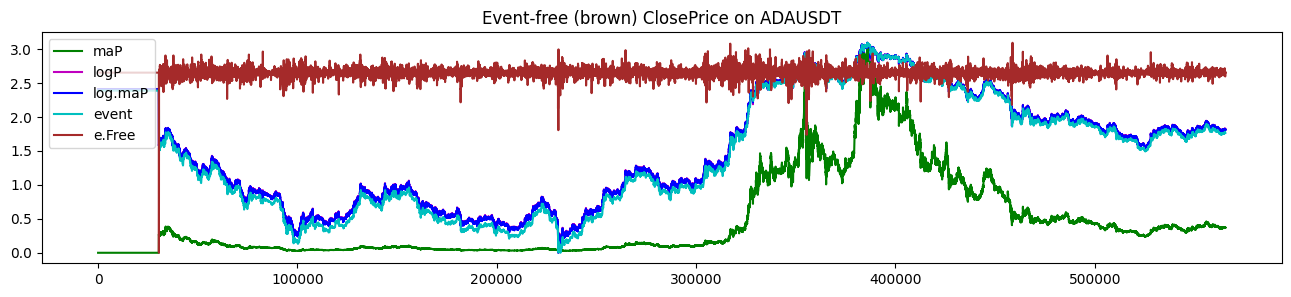

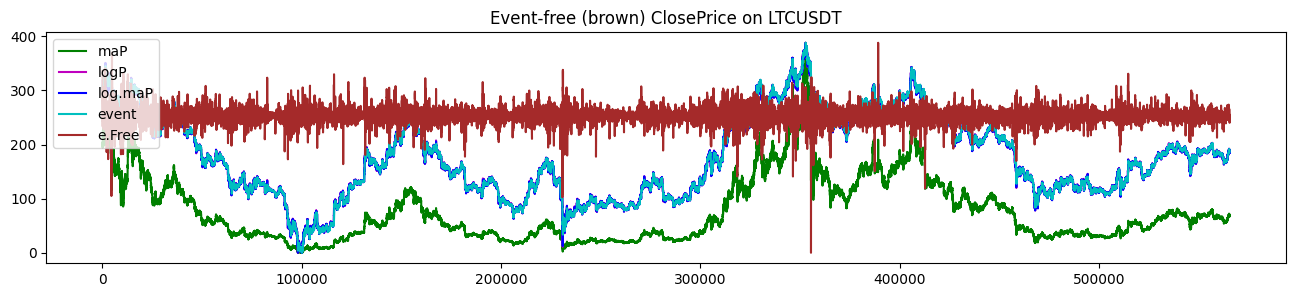

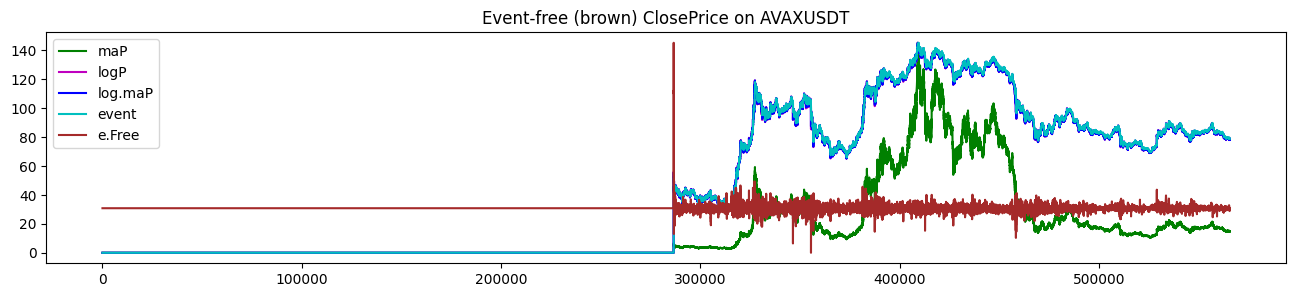

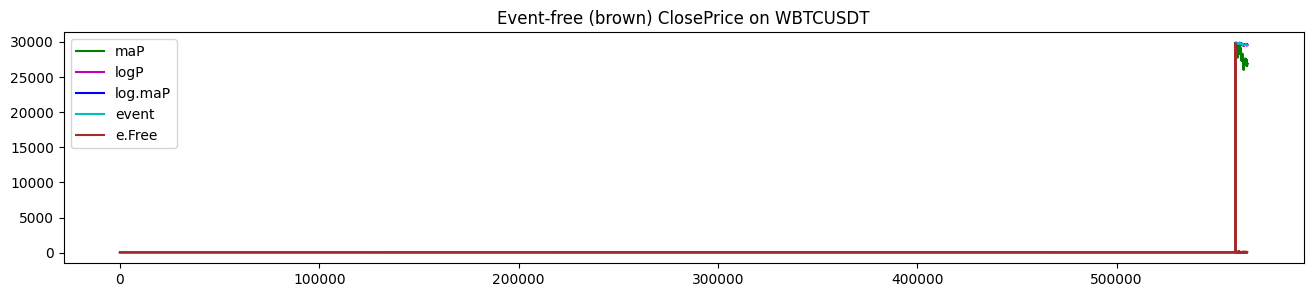

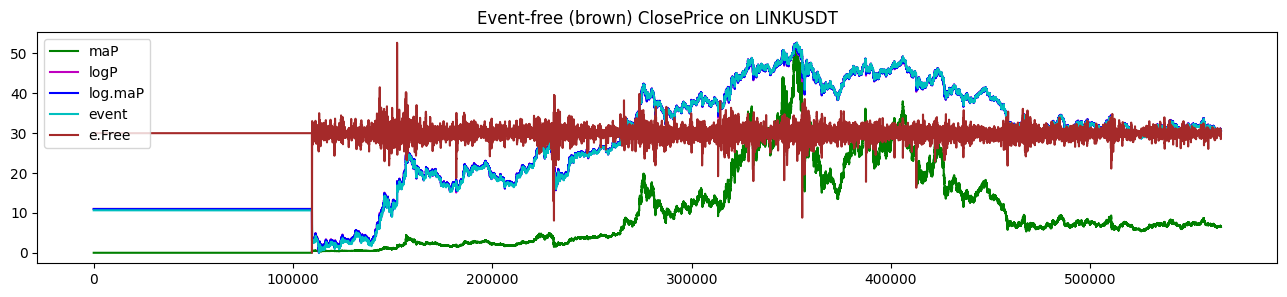

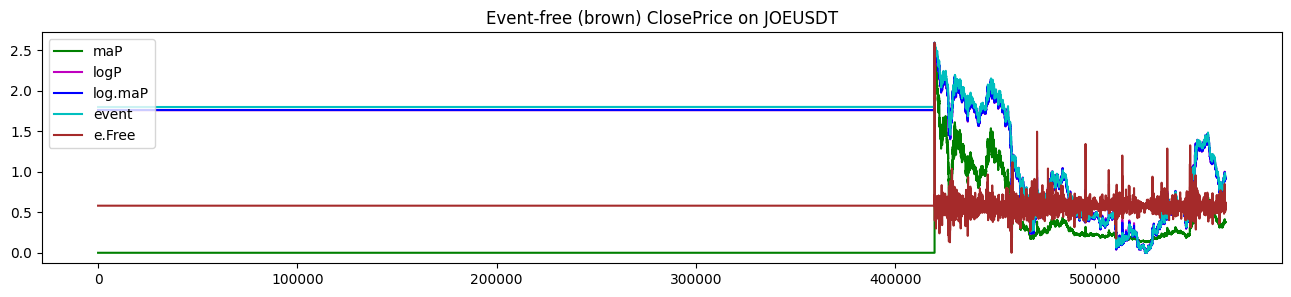

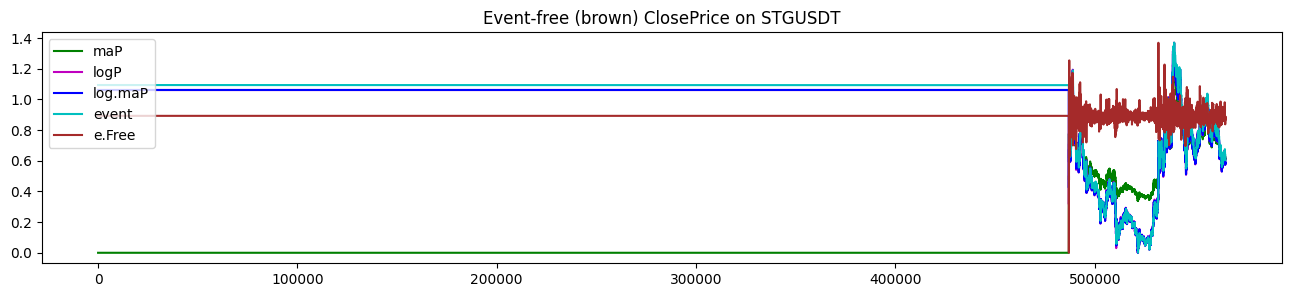

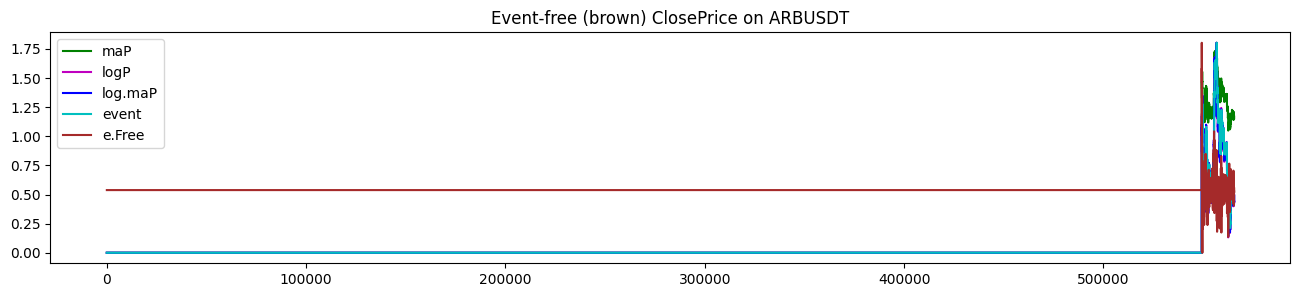

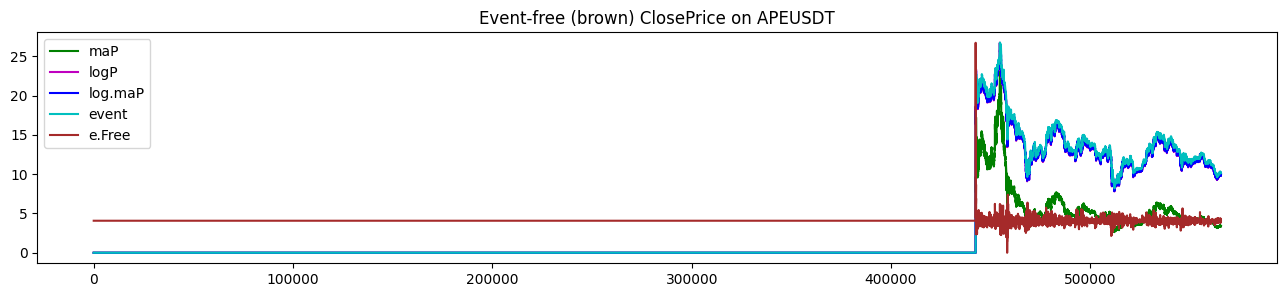

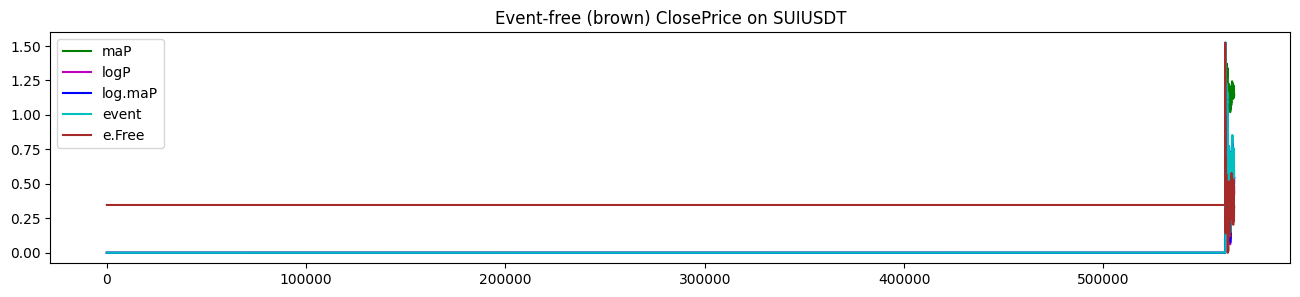

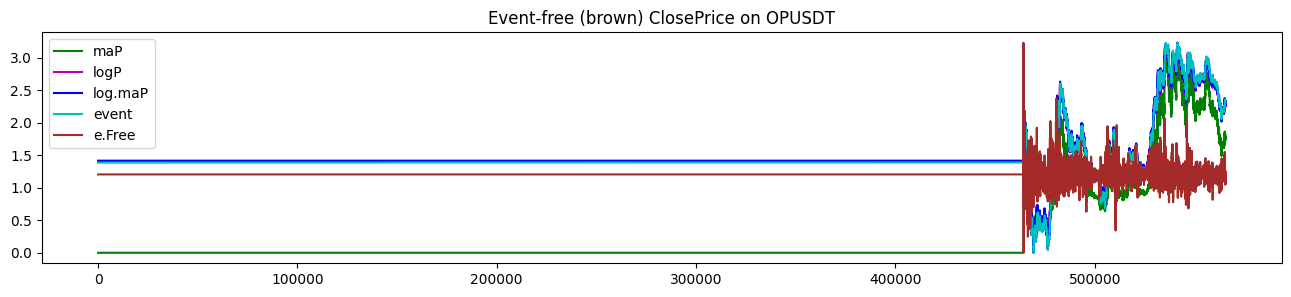

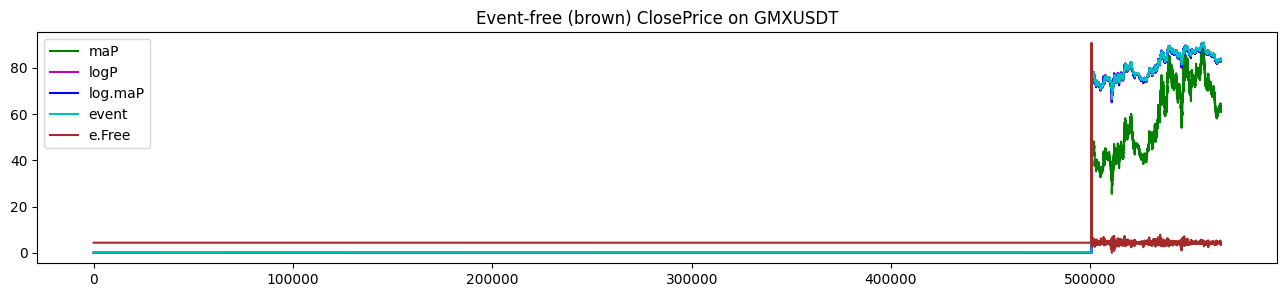

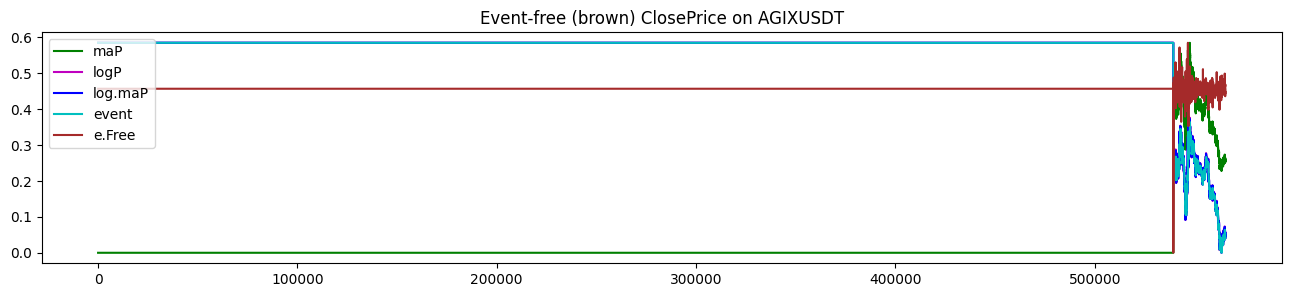

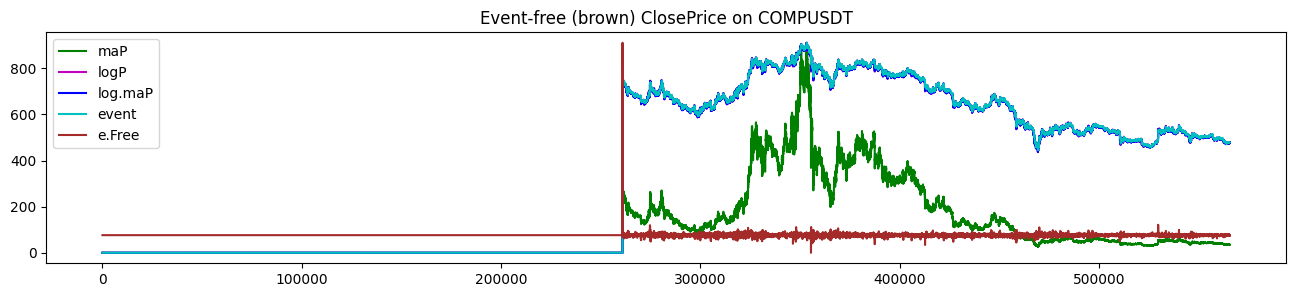

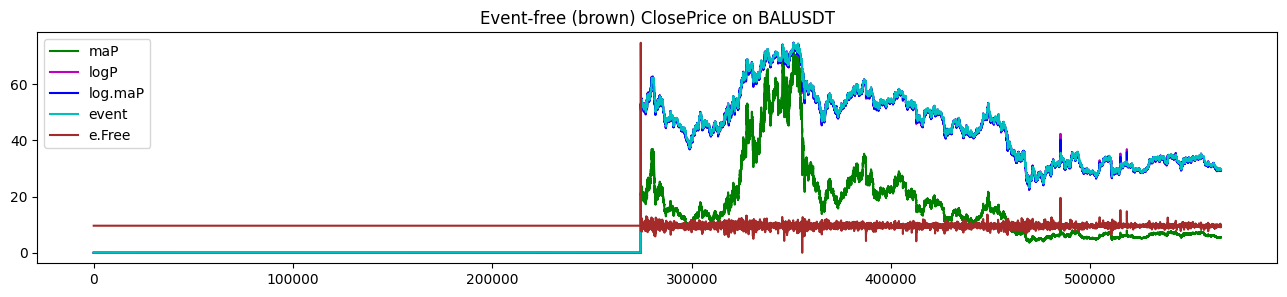

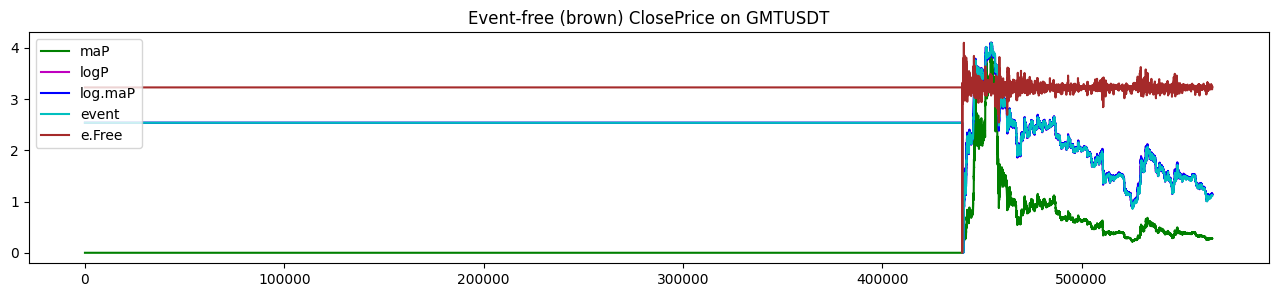

In [38]:
# Logarithmize + Smoothen
smallSigma = 1
largeSigma = 30

for market in chosen_markets:
    for field in chosen_fields:
        get_plot_log_feature(markets[market], enFields[field], Data[:, market, field], smallSigma, largeSigma, Data.shape[0] - 3 * (smallSigma + largeSigma))

In [39]:
# Trim in time dimension

In [40]:
# Normalize (linear)

In [41]:
# Add features, including time-info

hourly = np.sin( 2 * np.pi / (60*60) * timestamps )
daily = np.sin( 2 * np.pi / (60*60*24) * timestamps )
weekly = np.sin( 2 * np.pi / (60*60*24*7) * timestamps )
yearly = np.sin( 2 * np.pi / (60*60*24*365) * timestamps )


# A normalized representation of 'timestamps'
time_of_year_sin = np.sign( 2 * np.pi / (60*60*24*365) * timestamps )
time_of_year_cos = np.cos( 2 * np.pi / (60*60*24*365) * timestamps )
time_of_week_sin = np.sign( 2 * np.pi / (60*60*24*7) * timestamps )
time_of_week_cos = np.cos( 2 * np.pi / (60*60*24*7) * timestamps )
time_of_day_sin = np.sign( 2 * np.pi / (60*60*24) * timestamps )
time_of_day_cos = np.cos( 2 * np.pi / (60*60*24) * timestamps )

print(table.shape, hourly.shape)

# table = np.insert(table, 0, hourly.reshape(1), axis=0)

(565633, 336, 3) (565633,)


In [42]:
from sklearn.model_selection import train_test_split
Train, Valid = train_test_split(Data, test_size=0.30, random_state=42)
print(Train.shape, Valid.shape)

(395943, 336, 3) (169690, 336, 3)


In [43]:
Nx = 500
Ny = 5
Ns = 10
BatchSize = 64

sample_anchors_t = range(0, Train.shape[0] - Nx - Ny + 1, Ns)
print(Train.shape[0], len(sample_anchors_t), sample_anchors_t, sample_anchors_t[-1])
print(Data.shape[0], sample_anchors_t[ -1 ], sample_anchors_t[ -1 ] + Nx + Ny, sample_anchors_t[ -1 ] + Ns, sample_anchors_t[ -1 ] + Ns + Nx + Ny)

sample_anchors_v = range(0, Valid.shape[0] - Nx - Ny + 1, Ns)
print(Valid.shape[0], len(sample_anchors_v), sample_anchors_v, sample_anchors_v[-1])
print(Data.shape[0], sample_anchors_v[ -1 ], sample_anchors_v[ -1 ] + Nx + Ny, sample_anchors_v[ -1 ] + Ns, sample_anchors_v[ -1 ] + Ns + Nx + Ny)

395943 39544 range(0, 395439, 10) 395430
565633 395430 395935 395440 395945
169690 16919 range(0, 169186, 10) 169180
565633 169180 169685 169190 169695


In [44]:
nFiles_t = 70
nFiles_v = 30
n_readers = 5 #int(nFiles/2)

dir_datasets = "/mnt/data/Trading/Datasets"

name_prefix_t = os.path.join(dir_datasets, path + '_t')
name_prefix_v = os.path.join(dir_datasets, path + '_v')

reuse_files = True

if reuse_files:
    import re
    filenames_train = [ os.path.join(dir_datasets, x) for x in os.listdir(dir_datasets) if re.match(path + '_t', x)]
    filenames_valid = [ os.path.join(dir_datasets, x) for x in os.listdir(dir_datasets) if re.match(path + '_v', x)]
else:
    os.system("rm {}/*{}*".format(dir_datasets, path))
    filenames_train = save_to_multiple_csv_files(Train, sample_anchors_t, name_prefix_t, Nx, x_indices, Ny, y_indices, header=None, n_parts=nFiles_t)
    filenames_valid = save_to_multiple_csv_files(Valid, sample_anchors_v, name_prefix_v, Nx, x_indices, Ny, y_indices, header=None, n_parts=nFiles_v)

Dataset_train = csv_reader_dataset(filenames_train, Nx, size_x, Ny, size_y,
                             n_parse_threads=5, batch_size=BatchSize, shuffle_buffer_size=10000, n_readers=10)
Dataset_train = Dataset_train.prefetch(1)
# print(len(Dataset_train))

Dataset_valid = csv_reader_dataset(filenames_valid, Nx, size_x, Ny, size_y,
                             n_parse_threads=5, batch_size=BatchSize, shuffle_buffer_size=10000, n_readers=10)
Dataset_valid = Dataset_valid.prefetch(1)
# print(len(Dataset_valid))


Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_0:0", shape=(), dtype=string)


In [45]:
for element in Dataset_train:
    print(element)
    break

(<tf.Tensor: shape=(64, 500, 21), dtype=float32, numpy=
array([[[4.494000e+00, 3.920000e-01, 1.674299e+04, ..., 2.506000e-01,
         1.368000e-01, 3.684000e-01],
        [1.550600e+01, 2.523000e+00, 3.410937e+04, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, 9.822900e+03, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        ...,
        [0.000000e+00, 0.000000e+00, 5.298290e+03, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [6.289000e+00, 5.370000e-01, 2.805083e+04, ..., 3.827000e-01,
         5.894000e-01, 8.288000e-01],
        [6.220000e+00, 5.370000e-01, 2.212002e+04, ..., 4.176000e-01,
         2.419000e-01, 8.342000e-01]],

       [[4.234700e+00, 0.000000e+00, 1.134218e+04, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [3.907300e+01, 6.517200e+00, 5.740520e+04, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, 7.741150e+03, ..., 0.000000e

In [46]:
def mae_last_step(Y_true, Y_pred):
    return keras.mean(keras.abs(Y_pred[:, -1] - Y_true[:, -1]))

In [47]:
def huber_loss(y_true, y_pred, max_grad=1.):
    err = tf.abs(y_true - y_pred, name='abs')
    mg = tf.constant(max_grad, name='max_grad')
    lin = mg * (err - 0.5 * mg)
    quad = 0.5 * err * err
    return tf.where(err < mg, quad, lin)

In [48]:
from functools import partial
RegularizedLSTM = partial(keras.layers.LSTM,
                          return_sequences=True,
                          kernel_regularizer=keras.regularizers.l2(1e-4),
                          recurrent_regularizer=keras.regularizers.l2(1e-4))
# model3 = keras.models.Sequential()
# model3.add(RegularizedLSTM(100, input_shape=input_shape))
# model3.add(RegularizedLSTM(100))
# model3.add(keras.layers.Dense(1))
# model3.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(lr=0.01),
#                metrics=[mae_last_step])

In [49]:
input_dim = size_x
output_size = Ny * size_y

units = max(input_dim, output_size)

print(input_dim, units, output_size)

def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = RegularizedLSTM(units, input_shape=(None, input_dim), kernel_initializer="lecun_normal" )
        lstm_layer1 = RegularizedLSTM(units, input_shape=(None, units), kernel_initializer="lecun_normal" )
        lstm_layer2 = RegularizedLSTM(units, input_shape=(None, units), kernel_initializer="lecun_normal" )
        lstm_layer3 = RegularizedLSTM(units, input_shape=(None, units), kernel_initializer="lecun_normal" )
        lstm_layer4 = RegularizedLSTM(units, input_shape=(None, units), kernel_initializer="lecun_normal" )
        lstm_layer5 = RegularizedLSTM(units, input_shape=(None, units), kernel_initializer="lecun_normal" )
        lstm_layer6 = RegularizedLSTM(units, input_shape=(None, units), kernel_initializer="lecun_normal" )
        lstm_layer7 = RegularizedLSTM(units, input_shape=(None, units), kernel_initializer="lecun_normal" )
        lstm_layer8 = RegularizedLSTM(units, input_shape=(None, units), kernel_initializer="lecun_normal" )
        lstm_layer9 = keras.layers.LSTM(units, input_shape=(None, units), kernel_initializer="lecun_normal" )

    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(keras.layers.LSTMCell(units), input_shape=(None, input_dim), return_sequences=True)

    # with mirrored_strategy.scope():
    model = keras.models.Sequential(
        [
            lstm_layer,
            lstm_layer1,
            lstm_layer2,
            lstm_layer3,
            lstm_layer4,
            lstm_layer5,
            lstm_layer6,
            lstm_layer7,
            lstm_layer8,
            lstm_layer9,
            keras.layers.Dense(output_size, activation="selu", kernel_initializer="lecun_normal"),
            keras.layers.Dense(output_size, activation="selu", kernel_initializer="lecun_normal"),
            keras.layers.Dense(output_size, activation="selu", kernel_initializer="lecun_normal"),
            keras.layers.Dense(output_size, activation="selu", kernel_initializer="lecun_normal"),
            keras.layers.Dense(output_size, activation="selu", kernel_initializer="lecun_normal"),
        ]
    )

    model.compile(
        loss=keras.losses.MSE,
        optimizer=keras.optimizers.Adam(
            learning_rate=0.03,  # def lr = 0.001
            beta_1=0.9, 
            beta_2=0.999, 
            epsilon=1e-07
        ),
        metrics=keras.metrics.MSE,
    )

    return model

21 50 50


In [50]:
model = build_model(allow_cudnn_kernel=True)
model.summary()
# keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 50)          14400     
                                                                 
 lstm_1 (LSTM)               (None, None, 50)          20200     
                                                                 
 lstm_2 (LSTM)               (None, None, 50)          20200     
                                                                 
 lstm_3 (LSTM)               (None, None, 50)          20200     
                                                                 
 lstm_4 (LSTM)               (None, None, 50)          20200     
                                                                 
 lstm_5 (LSTM)               (None, None, 50)          20200     
                                                                 
 lstm_6 (LSTM)               (None, None, 50)          2

In [51]:
# options = tf.data.Options()
# options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
# train_data = Dataset_train.with_options(options)
# val_data = Dataset_valid.with_options(options)

history = model.fit(Dataset_train, validation_data=Dataset_valid, epochs=3)
# history_2= model.fit(Dataset_train, validation_data=Dataset_valid, epochs=10, initial epoch=history_1.epoch(-1) )

Epoch 1/3


2023-05-25 19:40:17.275237: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2023-05-25 19:40:18.546347: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


618/618 [==============================] - 194s 277ms/step - loss: 29198790.0000 - mean_squared_error: 29198790.0000 - val_loss: 28408572.0000 - val_mean_squared_error: 28408572.0000
Epoch 2/3
618/618 [==============================] - 174s 277ms/step - loss: 28434302.0000 - mean_squared_error: 28434302.0000 - val_loss: 28311176.0000 - val_mean_squared_error: 28311176.0000
Epoch 3/3
618/618 [==============================] - 167s 265ms/step - loss: 28419544.0000 - mean_squared_error: 28419544.0000 - val_loss: 28259174.0000 - val_mean_squared_error: 28259174.0000


In [55]:
def plot_history(history, loss="loss"):
    train_losses = history.history[loss]
    valid_losses = history.history["val_" + loss]
    n_epochs = len(history.epoch)
    minloss = np.min(valid_losses)
    
    plt.plot(train_losses, color="b", label="Train")
    plt.plot(valid_losses, color="r", label="Validation")
    plt.plot([0, n_epochs], [minloss, minloss], "k--",
             label="Min val: {:.2f}".format(minloss))
    plt.axis([0, n_epochs, int(minloss/2), int(minloss*3)])
    plt.legend()
    plt.show()

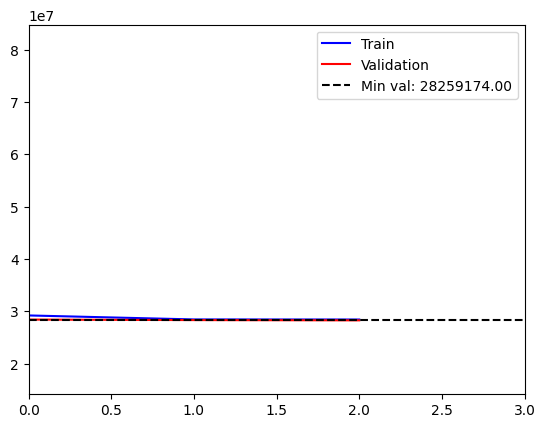

In [56]:
plot_history(history)

In [54]:
# history_2= model.fit(Dataset_train, validation_data=Dataset_valid, epochs=10, initial epoch=history_1.epoch(-1) )